In [1]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import pandas as pd
import numpy as np
import csv
import MeCab
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import re
import neologdn
import demoji
import emoji
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
# import seaborn as sns
# sns.set()
import japanize_matplotlib

model_dir = '/Users/iomacbookair2/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
# model_dir = '/Users/labimac/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
model_word2vec = KeyedVectors.load_word2vec_format(model_dir, binary=True)
mecab = MeCab.Tagger(
    '-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')


In [2]:
path = "/Users/iomacbookair2/Documents/lab/DEIM2023/tweet_csv/ann/220109_annkw.csv"
df = pd.read_csv((path))
df.sort_values(by = 'created_at', ascending = True, inplace = True)
df = df.reset_index(drop=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.drop("author_id", axis=1)
df = df.drop("username", axis=1)
df = df.drop("tweet_id", axis=1)
df = df.drop("like_count", axis=1)
df = df.drop("retweet_count", axis=1)
df

,created_at,text
0,2022-01-09 01:00:00,#annkw #オードリー #若林正恭 #春日俊彰
1,2022-01-09 01:00:00,#annkw
2,2022-01-09 01:00:00,#annkw
3,2022-01-09 01:00:00,#annkw
4,2022-01-09 01:00:00,土曜の夜(あけおめ) #annkw
...,...,...
11302,2022-01-09 03:04:01,表デルヤを久々に聴けてなんだか嬉しかった。今年もよろしくお願いします。 #annkw
11303,2022-01-09 03:04:09,@upgrade_japan #annkw お疲れ様でございます♪
11304,2022-01-09 03:04:15,お疲れ様でした ミッフィーちゃん、アディオス！ #annkw
11305,2022-01-09 03:04:26,スペシャルウィークゲストの時のコットン、最高に面白かった！！ #annkw


In [3]:
def preprocess(text):
    text = emoji.replace_emoji(text, replace=' ')
    text = re.sub(r'#\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'＃\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'@\S+', '', text) # @を消す
    text = re.sub(r'http?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text) # URLをスペースに置き換え
    text = re.sub(r'https?://\S+', ' ', text) # URLをスペースに置き換え
    text = re.sub(r'!-/:-@[-`{-~]', r'', text) # 記号を消す
    text = re.sub(r'”', '', text)  # "を消す
    text = re.sub(r'"', '', text)  # "を消す
    text = re.sub(r"'", "", text) # 'を消す
    text = re.sub(r'[(`)]', '', text)
    text = re.sub(
        "[\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\u3000-\u303F]", '', text)  # 記号を消す
    text = re.sub(
        u'[■♯【】「」『』;・ㅂﾟˊᗜ┏━┓┗┛ヾθ、し│/`:@`{-~。|∀!〇╰`′‵ˋω.*…╭∇^_￣´｀•˘д↑艸╯→°д̀ᴗ˃˂⁽⁾φ└＼※彡𖥦←ꂹ]', '', text)  # 記号を消す
    text = re.sub(r'(\d)([,.])(\d+)', r'\1\3', text) # 小数点とカンマを消す
    text = re.sub(r'\d+', '0', text) # 数字を0に置き換え
    text = text.lower() # 英字を小文字に
    text = re.sub(r"[\u3000\t\r\n]", " ", text) # 空白文字をスペースに置き換え
    text = neologdn.normalize(text)
    return text


df['text'] = df['text'].apply(preprocess)
df


,created_at,text
0,2022-01-09 01:00:00,
1,2022-01-09 01:00:00,
2,2022-01-09 01:00:00,
3,2022-01-09 01:00:00,
4,2022-01-09 01:00:00,土曜の夜あけおめ
...,...,...
11302,2022-01-09 03:04:01,表デルヤを久に聴けてなんだか嬉かった今年もよろくお願います
11303,2022-01-09 03:04:09,お疲れ様でございます♪
11304,2022-01-09 03:04:15,お疲れ様でたミッフィーちゃんアディオス
11305,2022-01-09 03:04:26,スペシャルウィークゲストの時のコットン最高に面白かった


In [4]:
# df.to_csv('preprocessed.csv', index=False)

In [5]:
import requests

url = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
r = requests.get(url)
tmp = r.text.split('\r\n')
stopwords = []
for i in range(len(tmp)):
    if len(tmp[i]) < 1:
        continue
    stopwords.append(tmp[i])

# stopwords += ["w", "ww", "www", "wwww", "wwwww", "笑",
#               "の", "し", "さ", "て", "れ", "ない", "てる",]

In [6]:
def words_list(sentence, model, mecab):
    if not sentence:
      pass
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
    #     filtered_words = [
    #         word for word in sentence_words if word not in stopwords]
    # return filtered_words
    return sentence_words


df["words"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else words_list(x, model_word2vec, mecab))
df


,created_at,text,words
0,2022-01-09 01:00:00,,0
1,2022-01-09 01:00:00,,0
2,2022-01-09 01:00:00,,0
3,2022-01-09 01:00:00,,0
4,2022-01-09 01:00:00,土曜の夜あけおめ,"[土曜, 夜, あけおめ]"
...,...,...,...
11302,2022-01-09 03:04:01,表デルヤを久に聴けてなんだか嬉かった今年もよろくお願います,"[デルヤ, 久, 聴け, なんだか, 嬉, かっ, 今年, よろく, 願い]"
11303,2022-01-09 03:04:09,お疲れ様でございます♪,[]
11304,2022-01-09 03:04:15,お疲れ様でたミッフィーちゃんアディオス,"[で, ミッフィー, ちゃん, アディオス]"
11305,2022-01-09 03:04:26,スペシャルウィークゲストの時のコットン最高に面白かった,"[スペシャルウィーク, ゲスト, 時, コットン, 最高, 面白かっ]"


In [7]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_words = pd.DataFrame({
    "words": groups.apply(lambda x: [word for sublist in x["words"] if type(sublist) == list for word in sublist])
})
df_words = df_words.reset_index()
df_words


,created_at,words
0,2022-01-09 01:00:00,"[土曜, 夜, あけおめ, 新年, 0回目, 0, 年, 人吉, 温泉郷, joar, なう..."
1,2022-01-09 01:01:00,"[土曜, 夜, カスミン, ひと, 兄弟, 番組, w, 若, オードリー, 若林, 春, ..."
2,2022-01-09 01:02:00,"[兄弟, 番組, 春日, さん, いわく, 兄弟, 番組, オードリーのオールナイトニッポン..."
3,2022-01-09 01:03:00,"[ラベリング, する, 作業, 苦労, する, 若林, さん, 覇王, 目指す, 楽, み,..."
4,2022-01-09 01:04:00,"[taiga, 今年, 売れる, 写真, 若林, さん, ウッチャン, 似, すぎ, ありが..."
...,...,...
120,2022-01-09 03:00:00,"[アディオス, 今年, ひとつ, なに, 日本, トレンド, top, 0, bot, 0,..."
121,2022-01-09 03:01:00,"[ミッフィー, ちゃん, 新年, 一, 発, 目, 今週, で, 来週, アディオス, チン..."
122,2022-01-09 03:02:00,"[オードリー, バトン, 0, 年, 快調, 滑り出, 0時, 間, やっと, 通常, 日,..."
123,2022-01-09 03:03:00,"[何, 気, annkw, 最後, 聞い, 初めて, で, ー, で, ー, 今宵, めちゃ..."


In [8]:
# df_words.to_csv('words.csv', index=False)

In [9]:
def save_wordclowd(words, index):
    if len(words) == 0:
        plt.axis("off")
    else:
        wordcloud = WordCloud(background_color="white", width=600, height=400, min_font_size=15,
                              font_path='/Users/iomacbookair2/Library/Fonts/IBMPlexSansJP-Regular.otf').generate(' '.join(words))
        plt.axis("off")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.savefig(f"{index+1}.png")
    plt.clf()


df_words.apply(lambda x: save_wordclowd(x["words"], x.name), axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
120    None
121    None
122    None
123    None
124    None
Length: 125, dtype: object

<Figure size 640x480 with 0 Axes>

In [10]:
def word_to_vec(sentence, model, mecab):
    if not sentence:
        sentence_embedding = np.zeros(200, dtype=np.float32)
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
                # if parts[1].startswith("名詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("動詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("形容詞"):
                #     sentence_words.append(features[6])
        # print(sentence_words)
        if all(re.match(r'.*[a-zA-Z].*', word) for word in sentence_words):
            sentence_embedding = np.zeros(200, dtype=np.float32)
        else:
            word_vectors = [model[word]
                            for word in sentence_words if word in model]
            if word_vectors:
                if len(word_vectors) == 0:
                    sentence_embedding = np.zeros(200, dtype=np.float32)
                else:
                    sentence_embedding = np.mean(word_vectors, axis=0)
            else:
                sentence_embedding = np.zeros(200, dtype=np.float32)
    return sentence_embedding

df["vector"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else word_to_vec(x, model_word2vec, mecab))
df = df.drop("text", axis=1)
df = df.drop("words", axis=1)
df


,created_at,vector
0,2022-01-09 01:00:00,0
1,2022-01-09 01:00:00,0
2,2022-01-09 01:00:00,0
3,2022-01-09 01:00:00,0
4,2022-01-09 01:00:00,"[1.8141619, -0.5852078, -1.4259241, 0.06389692..."
...,...,...
11302,2022-01-09 03:04:01,"[0.6487841, 0.3863302, 0.3324263, -0.34499794,..."
11303,2022-01-09 03:04:09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
11304,2022-01-09 03:04:15,"[-0.0411508, -0.3835486, 0.36857468, 0.1423319..."
11305,2022-01-09 03:04:26,"[0.0332856, 0.14558367, -0.78356296, 0.2440242..."


In [11]:
# df.to_csv('vector.csv', index=False)

In [12]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_vectors = pd.DataFrame({
    "vectors": groups.apply(lambda x: x["vector"].tolist())
})
df_vectors = df_vectors.reset_index()
df_vectors


,created_at,vectors
0,2022-01-09 01:00:00,"[0, 0, 0, 0, [1.8141619, -0.5852078, -1.425924..."
1,2022-01-09 01:01:00,"[[1.8141619, -0.5852078, -1.4259241, 0.0638969..."
2,2022-01-09 01:02:00,"[0, 0, [0.7172116, -0.5687782, 1.2316793, 1.20..."
3,2022-01-09 01:03:00,"[[-0.38402516, 1.2811757, -0.60963833, -1.1572..."
4,2022-01-09 01:04:00,"[[-0.07934284, -1.0322582, 0.6744418, 0.442025..."
...,...,...
120,2022-01-09 03:00:00,"[[-0.1224008, -0.157669, -0.018961495, 0.06063..."
121,2022-01-09 03:01:00,"[[-0.05384178, -0.13177954, 0.41583714, 0.3411..."
122,2022-01-09 03:02:00,"[[-0.12730584, -0.46866006, -0.17111361, -0.51..."
123,2022-01-09 03:03:00,"[[0.3923404, -0.002666201, -1.006917, 0.290843..."


In [13]:
def calc_similarity(vector1, vector2):
  similarity = cosine_similarity(vector1, vector2)[0][0]
  return similarity


def calc_average_similarity(vectors, key):
    similarities = []
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            if np.all(vectors[i] == 0) or np.all(vectors[j] == 0):
                continue
            else:
                similarity = calc_similarity(vectors[i].reshape(1, -1), vectors[j].reshape(1, -1))
            similarities.append(similarity)
    q = [0, 0.25, 0.5, 0.75, 1]
    outputs = {}
    for i in range(len(q)):
        outputs[f"q{i}"] = np.quantile(similarities, q[i])
    outputs["standard_deviation"] = np.std(similarities)
    outputs["mean"] = np.mean(similarities)
    if key == "q2":
        return outputs["q2"]
    elif key == "q1":
        return outputs["q1"]
    elif key == "q3":
        return outputs["q3"]
    elif key == "standard_deviation":
        return outputs["standard_deviation"]
    elif key == "mean":
        return outputs["mean"]


In [14]:
df_vectors["q1"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q1"))
df_vectors["q2"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q2"))
df_vectors["q3"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q3"))
df_vectors["mean"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "mean"))
df_vectors["stdev"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "standard_deviation"))
df_vectors = df_vectors.drop("vectors", axis=1)
df_vectors


,created_at,q1,q2,q3,mean,stdev
0,2022-01-09 01:00:00,0.158624,0.348612,0.573685,0.404539,0.311069
1,2022-01-09 01:01:00,0.088554,0.217594,0.373963,0.285990,0.280820
2,2022-01-09 01:02:00,0.166541,0.301226,0.544485,0.365472,0.266623
3,2022-01-09 01:03:00,0.195517,0.316219,0.492755,0.354348,0.218198
4,2022-01-09 01:04:00,0.154912,0.294656,0.468849,0.319501,0.218653
...,...,...,...,...,...,...
120,2022-01-09 03:00:00,0.273058,0.448326,0.732657,0.487803,0.306178
121,2022-01-09 03:01:00,0.309324,0.428244,0.518928,0.422157,0.164900
122,2022-01-09 03:02:00,0.260128,0.401886,0.517392,0.386948,0.179149
123,2022-01-09 03:03:00,0.282079,0.390526,0.505932,0.389485,0.161876


In [15]:
df_vectors.to_csv('similarity.csv', index=False)


In [16]:
path_count = "/Users/iomacbookair2/Documents/lab/DEIM2023/word2vec/220109_ann/count.csv"
df_count = pd.read_csv((path_count))
df_vectors["tweet"] = df_count["tweet"]
df_vectors['created_at'] = df_vectors['created_at'].astype(str)
start_time = df_vectors['created_at'].min()
start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: (
    datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - start_time).total_seconds() / 60 +1)
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: round(x))
df_vectors


,created_at,q1,q2,q3,mean,stdev,tweet
0,1,0.158624,0.348612,0.573685,0.404539,0.311069,902
1,2,0.088554,0.217594,0.373963,0.285990,0.280820,404
2,3,0.166541,0.301226,0.544485,0.365472,0.266623,225
3,4,0.195517,0.316219,0.492755,0.354348,0.218198,165
4,5,0.154912,0.294656,0.468849,0.319501,0.218653,133
...,...,...,...,...,...,...,...
120,121,0.273058,0.448326,0.732657,0.487803,0.306178,68
121,122,0.309324,0.428244,0.518928,0.422157,0.164900,20
122,123,0.260128,0.401886,0.517392,0.386948,0.179149,15
123,124,0.282079,0.390526,0.505932,0.389485,0.161876,10


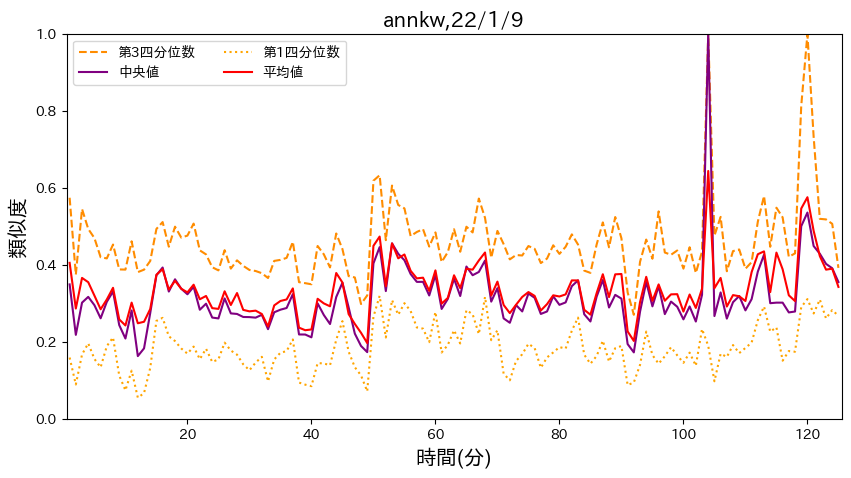

In [17]:
window_sizes = [1]
for window in window_sizes:
    df_vectors['q1'] = df_vectors['q1'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q2'] = df_vectors['q2'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q3'] = df_vectors['q3'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "annkw,22/1/9", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows+0.5)
    ax.set_ylim(0, 1)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("類似度", fontsize=15)
    ax.plot(df_vectors["created_at"], df_vectors["q3"], color="darkorange", linestyle="dashed",
            label="第3四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["q2"], color="purple",
            label="中央値")
    ax.plot(df_vectors["created_at"], df_vectors["q1"], color="orange", linestyle="dotted",
            label="第1四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["mean"], color="red",
            label="平均値")
    ax.legend(loc="upper left",  ncol=2)
    plt.savefig('quantile.png')


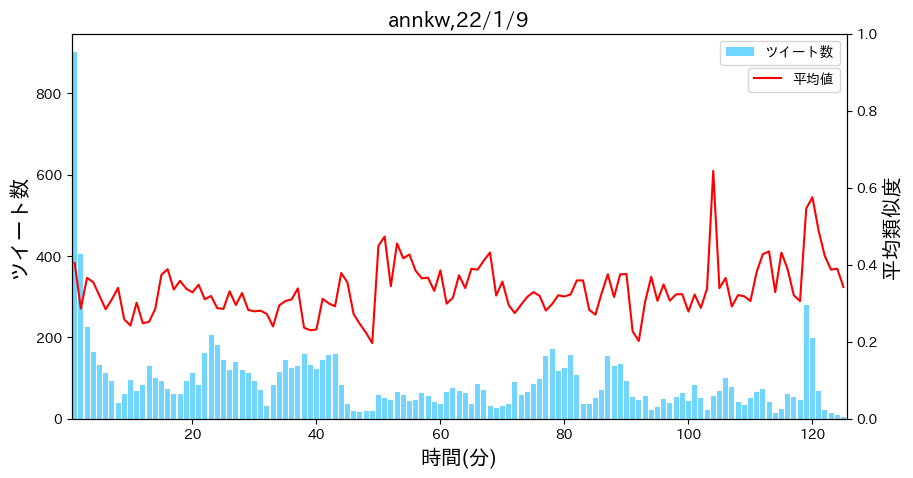

In [18]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    # df_vectors['stdev'] = df_vectors['stdev'].rolling(
    #     window=window, min_periods=1).mean()
    # df_vectors['alpha_m'] = df_vectors['mean'] - df_vectors['stdev']
    # df_vectors['alpha_p'] = df_vectors['mean'] + df_vectors['stdev']

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "annkw,22/1/9", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("平均類似度", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["mean"], color="red", label="平均値")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_m"], color="orange", linestyle="dashed")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_p"], color="orange", linestyle="dashed",label="68%信頼区間")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.93))
    plt.savefig('mean.png')


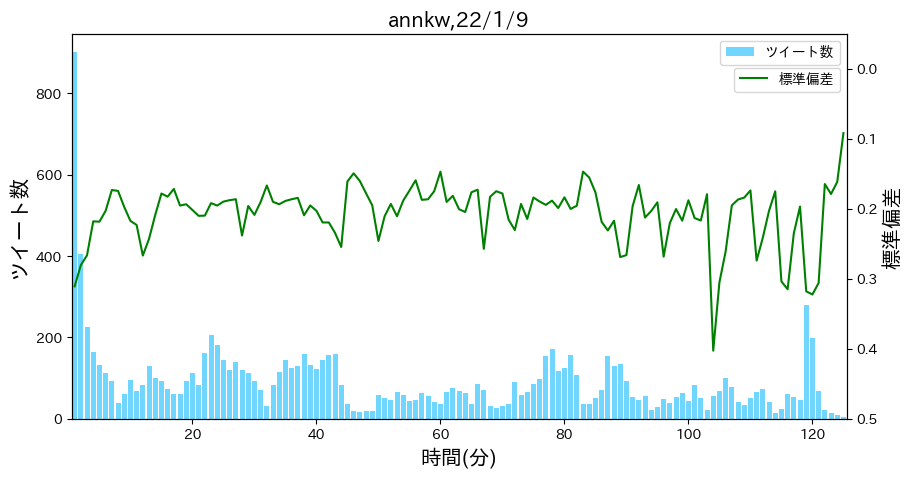

In [19]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['stdev'] = df_vectors['stdev'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "annkw,22/1/9", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0.5, -0.05)
    ax2.set_ylabel("標準偏差", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["stdev"], color="green",
             label="標準偏差")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.93))
    plt.savefig('stdev.png')
